# Comparison of Sampling Techniques in Solving PDEs with NNs

In [20]:
import time

import torch
import chaospy
import numpy as np
from tqdm import trange
from torch import nn, autograd, optim

import matplotlib.pyplot as plt
%matplotlib notebook

from nets import *
from graphics import *

In [2]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x), u(t, 0) = gauss(0)}
# Also, it is used here to set initial or boundary conditions in other equations
def dome(x, t=0, a=.5, alpha=200, shift=0.25):
    if isinstance(t, torch.Tensor):
        t = t[:, None]
    psi = torch.exp(-alpha*torch.tensor(shift**2))
    res = torch.exp(-alpha*(x-shift-a*t)**2)
    out = torch.empty_like(res).fill_(psi.item())
    out[x - a*t > 0] = res[x - a*t > 0]
    
    return out

In [3]:
class PDE2D(nn.Module):
    """
    Base class
    ----------
    Args:
    -----
    l                 length of calculation area along x axis
                      (starting from 0)
    T                 length of calculation area along t axis
                      (starting from 0)

                      Thus, (0, l) x (0, T) is the training domain
    """
    def __init__(self, l=1., T=2., device='cpu'):
        super().__init__()
        self.l = l
        self.T = T
        self.device = device
    
    def sampleBatch(self, N=5120, M=4096, K=4096, sampling='rand', seed=1):
        """
        N - number of points to sample in the domain (x, t)
        M - __..__..__..__..__ to sample on the x axis
        """
        x = torch.zeros(M, 2, device=self.device)
        if sampling=='rand':
            x_rand_points = np.random.rand(M)
        elif sampling=='halton':
            x_rand_points = chaospy.distributions.sampler.sequences.halton.create_halton_samples(M, dim=1, burnin=seed*64).squeeze()
        elif sampling=='sobol':
            x_rand_points = chaospy.distributions.sampler.sequences.sobol.create_sobol_samples(M, dim=1, seed=np.random.randint(100)).squeeze()
        elif sampling=='grid':
            x_rand_points = chaospy.distributions.sampler.sequences.grid.create_grid_samples(M, dim=1).squeeze()
        x[:, 1] = self.l * torch.tensor(x_rand_points, dtype=torch.float32, device=self.device)
        
        t0 = torch.zeros(K, 2, device=self.device)
        if sampling=='rand':
            t_rand_points = np.random.rand(K)
        elif sampling=='halton':
            t_rand_points = chaospy.distributions.sampler.sequences.halton.create_halton_samples(K, dim=1, burnin=seed*64).squeeze()
        elif sampling=='sobol':
            t_rand_points = chaospy.distributions.sampler.sequences.sobol.create_sobol_samples(K, dim=1, seed=np.random.randint(100)).squeeze()
        elif sampling=='grid':
            t_rand_points = chaospy.distributions.sampler.sequences.grid.create_grid_samples(K, dim=1).squeeze()
        t0[:, 0] = self.T * torch.tensor(t_rand_points, dtype=torch.float32, device=self.device)

        if sampling=='rand':
            tx_rand_points = np.random.rand(N, 2)
        elif sampling=='halton':
            tx_rand_points = chaospy.distributions.sampler.sequences.halton.create_halton_samples(N, dim=2, burnin=seed*64).transpose()
        elif sampling=='sobol':
            tx_rand_points = chaospy.distributions.sampler.sequences.sobol.create_sobol_samples(N, dim=2, seed=np.random.randint(100)).transpose()
        elif sampling=='grid':
            tx_rand_points = chaospy.distributions.sampler.sequences.grid.create_grid_samples(N, dim=2).transpose()
        tx = torch.tensor(tx_rand_points, dtype=torch.float32, device=self.device)
        tx[:, 0].mul_(self.T)
        tx[:, 1].mul_(self.l)

        return tx, x, t0
    
    def _D(self, y, x):
        grad = autograd.grad(
            outputs=y, inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True, allow_unused=True)[0]
            
        return grad

In [4]:
class AdvectionPDE(PDE2D):
    """
    Homogeneous Advection Equation
    -------------------------------------
    du/dt + a du/dx = 0
    u(0, x) = gauss(x)
    -------------------------------------
    Args:
    -----
    a                 wave velocity
    """
    def __init__(self, a=.5, l=1., T=2., device='cpu'):
        super().__init__(l, T, device)
        self.a = a
        self.psi = torch.tensor([0.], device=device)

    def computeLoss(self, tx, x, t, net):
        du_t, du_x = torch.unbind(self._D(net(tx), tx), 1)
        L = (torch.norm(du_t + self.a * du_x)
             + torch.norm(net(x) - dome(x[:, 1], a=self.a))
             + torch.norm(net(t) - self.psi))
            
        return L

In [5]:
def train(net, pde, optimizer, loss_history, batch_sizes=(5120, 4096, 4096), sampling='rand'):
    for i, _ in enumerate(trange(num_batches, desc='Training')):
        optimizer.zero_grad()
     
        batches = pde.sampleBatch(*batch_sizes, sampling, i)
        batches[0].requires_grad_(True)
     
        loss = pde.computeLoss(*batches, net)
        loss_history.append(loss.item())
        loss.backward()
     
        optimizer.step()

## DGM net

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)

pde = AdvectionPDE()
#pde = FisherPDE()

# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

net = DGM(d=1, M=50, L=3).to(device)
# net_rand = DumbLinear('3l', base_width=128).to(device)
# net_halton = DumbLinear('3l', base_width=128).to(device)
# net_sobol = DumbLinear('3l', base_width=128).to(device)


n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer_halton = optim.Adam(net.parameters())

You have 0 gpus


In [7]:
loss_history = []
train(net, pde, optimizer_halton, loss_history, (128, 128, 128), sampling='halton')

Training: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [09:04<00:00, 18.37it/s]


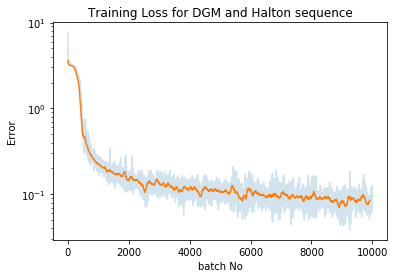

In [8]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss for DGM and Halton sequence')
plt.ylabel('Error')
plt.xlabel('batch No');

<IPython.core.display.Javascript object>


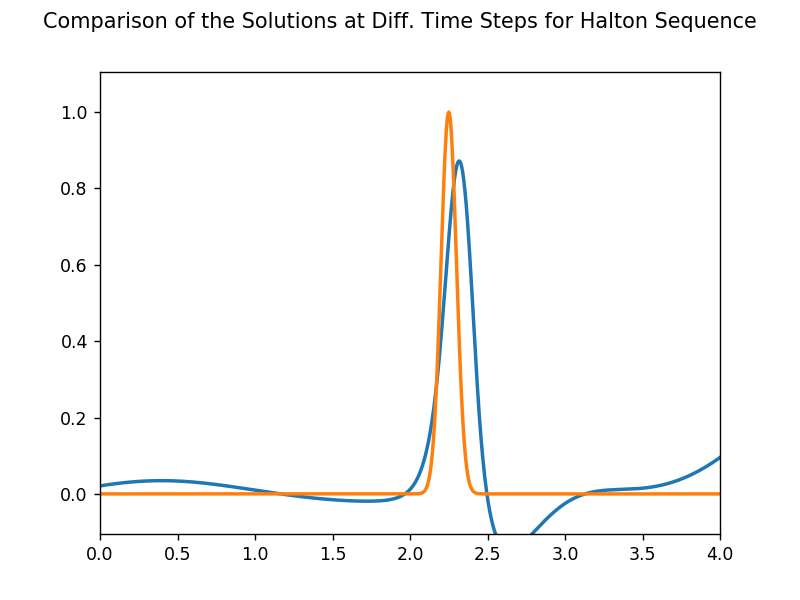

In [21]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
tx = torch.stack((t, x), -1)
y = net(tx.to(device)).view(len(tx), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps for Halton Sequence')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

## FC3 NN

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)

pde = AdvectionPDE()
#pde = FisherPDE()

# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

#net = DGM(d=1, M=50, L=3).to(device)
net_rand = DumbLinear('3l', base_width=128).to(device)
net_halton = DumbLinear('3l', base_width=128).to(device)
net_sobol = DumbLinear('3l', base_width=128).to(device)


n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer_rand = optim.Adam(net_rand.parameters())
optimizer_halton = optim.Adam(net_halton.parameters())
optimizer_sobol = optim.Adam(net_sobol.parameters())
losses_history = []

You have 0 gpus


In [11]:
loss_history = []
train(net_rand, pde, optimizer_rand, loss_history, (128, 128, 128), sampling='rand')
losses_history.append(loss_history)

loss_history = []
train(net_halton, pde, optimizer_halton, loss_history, (128, 128, 128), sampling='halton')
losses_history.append(loss_history)

loss_history = []
train(net_sobol, pde, optimizer_sobol, loss_history, (128, 128, 128), sampling='sobol')
losses_history.append(loss_history)

Training: 100%|██████████████████████████████████████████████████████████████████| 10000/10000 [05:06<00:00, 35.80it/s]


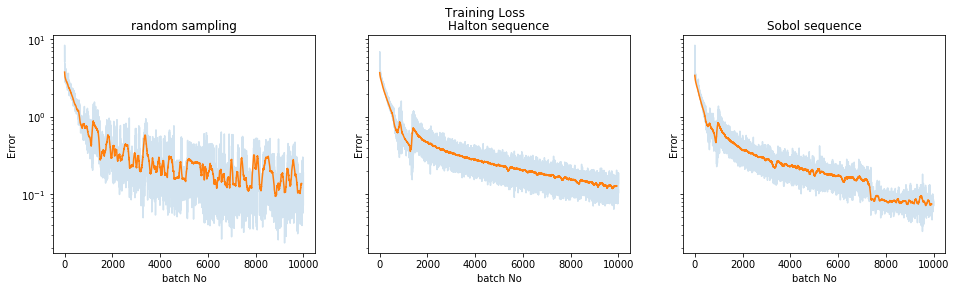

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
fig.suptitle('Training Loss', fontsize='large')

axes[0].semilogy(losses_history[0], alpha=.2)
axes[0].semilogy(running_mean(losses_history[0]))
axes[0].set_title('random sampling')
axes[0].set_ylabel('Error') 
axes[0].set_xlabel('batch No')

axes[1].semilogy(losses_history[1], alpha=.2)
axes[1].semilogy(running_mean(losses_history[1]))
axes[1].set_title('Halton sequence')
axes[1].set_ylabel('Error') 
axes[1].set_xlabel('batch No')


axes[2].semilogy(losses_history[2], alpha=.2)
axes[2].semilogy(running_mean(losses_history[2]))
axes[2].set_title('Sobol sequence')
axes[2].set_ylabel('Error') 
axes[2].set_xlabel('batch No')

plt.show()

In [13]:
max_error = lambda u_exact, u_approx: torch.norm(u_exact - u_approx, p=float('inf'))
avg_error = lambda u_exact, u_approx: torch.mean((u_exact - u_approx)**2)**.5 

## Initial condition approximation

max error 0.028821760788559914
avg error 0.01923113502562046


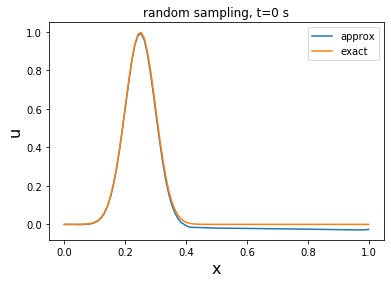

In [14]:
x = torch.linspace(0, 1)
tx = torch.stack((torch.zeros_like(x), x), 1)

y_true = dome(x)
y = net_rand(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('random sampling, t=0 s')
plt.legend();

max error 0.01746419072151184
avg error 0.012004239484667778


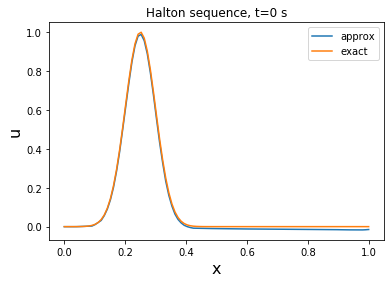

In [15]:
x = torch.linspace(0, 1)
tx = torch.stack((torch.zeros_like(x), x), 1)

y_true = dome(x)
y = net_halton(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('Halton sequence, t=0 s')
plt.legend();

max error 0.009901374578475952
avg error 0.004294834565371275


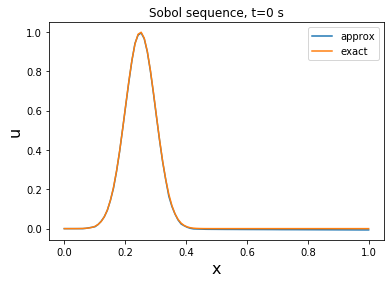

In [16]:
x = torch.linspace(0, 1)
tx = torch.stack((torch.zeros_like(x), x), 1)

y_true = dome(x)
y = net_sobol(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('Sobol sequence, t=0 s')
plt.legend();

## Approximation at time `t`

max error 0.024066677317023277
avg error 0.011910829693078995


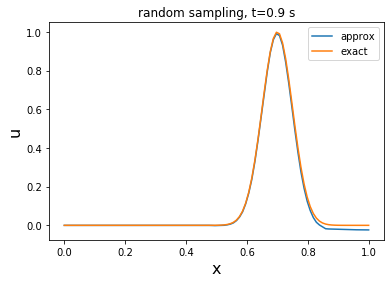

In [17]:
t = .9 
x = torch.linspace(0, 1)
tx = x.new(len(x), 2)
tx[:, 0].fill_(t)
tx[:, 1] = x

y_true = dome(x, t)
y = net_rand(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f'random sampling, t={t} s')
plt.legend();

max error 0.028261572122573853
avg error 0.011069445870816708


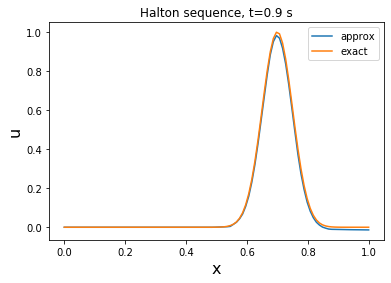

In [18]:
t = .9 
x = torch.linspace(0, 1)
tx = x.new(len(x), 2)
tx[:, 0].fill_(t)
tx[:, 1] = x

y_true = dome(x, t)
y = net_halton(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f'Halton sequence, t={t} s')
plt.legend();

max error 0.0687021017074585
avg error 0.015452062711119652


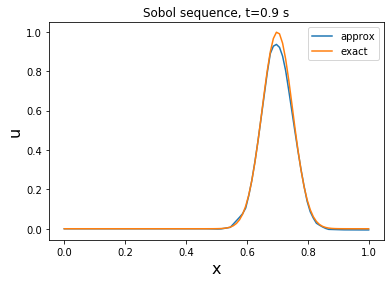

In [19]:
t = .9 
x = torch.linspace(0, 1)
tx = x.new(len(x), 2)
tx[:, 0].fill_(t)
tx[:, 1] = x

y_true = dome(x, t)
y = net_sobol(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f'Sobol sequence, t={t} s')
plt.legend();

## Run cell to start animating
if there is only one graph, re-run the cell

---
As expected, the approximation is fairly good on the training data, and when the model encounters test data the solutions begin to diverge

<IPython.core.display.Javascript object>


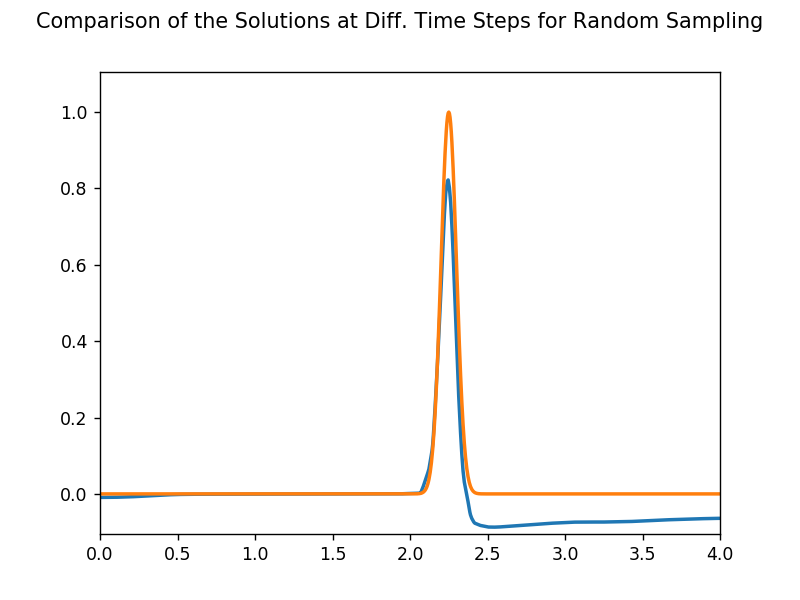

In [44]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
tx = torch.stack((t, x), -1)
y = net_rand(tx.to(device)).view(len(tx), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps for Random Sampling')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

<IPython.core.display.Javascript object>


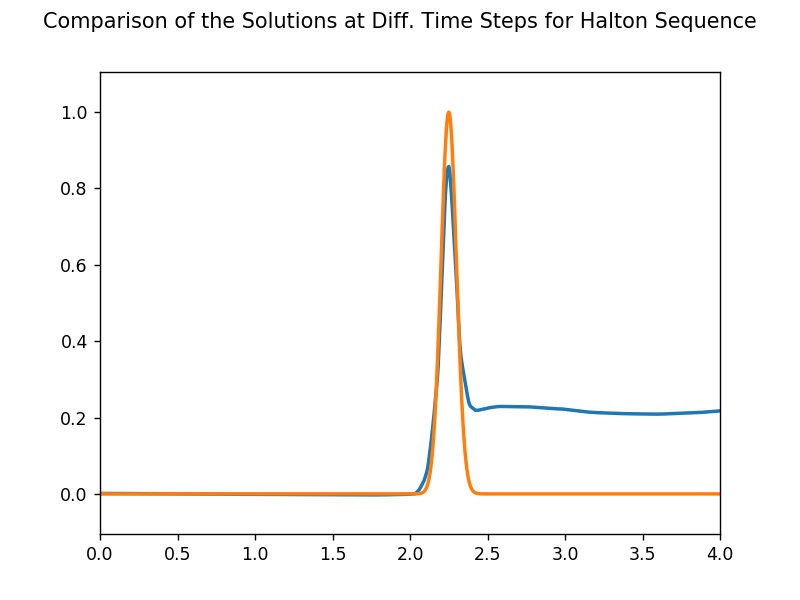

In [50]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
tx = torch.stack((t, x), -1)
y = net_halton(tx.to(device)).view(len(tx), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps for Halton Sequence')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

<IPython.core.display.Javascript object>


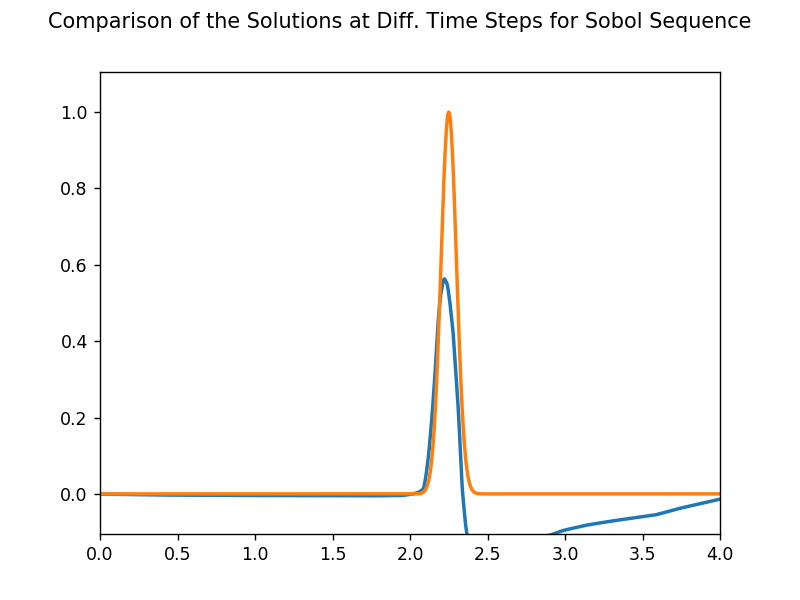

In [39]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
tx = torch.stack((t, x), -1)
y = net_sobol(tx.to(device)).view(len(tx), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps for Sobol Sequence')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

---
## Solving the problem with finite-difference method

$$
\left\{\begin{aligned}
    &u_i^{n+1} = u_i^n + a\Delta t (u_{i-1}^n- u_i^n)\\
    &u_i^0 = \exp(-\alpha(i\Delta h - 0.25)^2)\\
    &u_0^n = 0
\end{aligned}\right.
$$

In [24]:
l = 1
T = 1
u_t0 = torch.tensor([0.])
dx = 1e-3
rdx = 1 / dx
dt = 2e-3
a = .5

x = torch.linspace(0, l, int(l/dx))
u_0x = dome(x, a=a)
u_exact = dome(x, t=T, a=a)

def one_time_step(u):
    return u + torch.cat([u_t0, -a*dt*rdx * (u[1:] - u[:-1])])

In [25]:
u1 = u_0x
for i in range(int(.5 * T / dt)):
    u2 = one_time_step(u1)
    u1 = one_time_step(u2)

max error 0.0060707926750183105
avg error 0.0021060598082840443


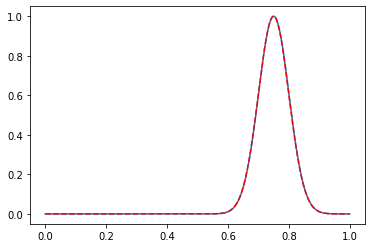

In [26]:
plt.figure()
print('max error', max_error(u_exact, u1).item())
print('avg error', avg_error(u_exact, u1).item())
plt.plot(x.numpy(), u1.numpy())
plt.plot(x.numpy(), u_exact.numpy(), '--r');